In [2]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade pyspark

Note: you may need to restart the kernel to use updated packages.


***1. Data Loading and Initial Exploration***

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, min, max
from pyspark.sql.functions import avg, stddev, expr

In [6]:
spark = SparkSession.builder \
    .appName("AnimeDatasetApplication") \
    .getOrCreate()


# Set Spark log level to ERROR to suppress warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/06 22:24:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/06 22:24:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/11/06 22:24:25 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/11/06 22:24:25 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/11/06 22:24:25 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
24/11/06 22:24:25 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.


In [7]:
# Now you can read the CSV file
df = spark.read.csv("animedataset.csv", header=True, inferSchema=True)

# Repartition data for better performance
df = df.repartition(4)


In [8]:
# Display the schema of the dataset
df.printSchema()

# Show the first 10 rows of the dataset
df.show(10, truncate=False)


root
 |-- username: string (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- my_score: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- source: string (nullable = true)
 |-- score: string (nullable = true)
 |-- scored_by: double (nullable = true)
 |-- rank: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- genre: string (nullable = true)



+------------+--------+--------+-------+------+-----------------------------------------+-----+------------+-----+---------+------+----------+---------------------------------------------------------+
|username    |anime_id|my_score|user_id|gender|title                                    |type |source      |score|scored_by|rank  |popularity|genre                                                    |
+------------+--------+--------+-------+------+-----------------------------------------+-----+------------+-----+---------+------+----------+---------------------------------------------------------+
|Ilardii     |9936    |0       |4614676|Male  |Maken-Ki!                                |TV   |Manga       |6.62 |70384.0  |5123.0|580.0     |Action, Ecchi, Harem, Martial Arts, School, Super Power  |
|slipkorna   |6880    |7       |201829 |Male  |Deadman Wonderland                       |TV   |Manga       |7.41 |368860.0 |1966.0|53.0      |Action, Sci-Fi, Horror, Shounen                       

In [9]:
# Count the total number of rows in the dataset
total_rows = df.count()
print(f"Total number of rows: {total_rows}")


Total number of rows: 35305695


The above code snippets sets up a PySpark application called "AnimeDatasetApplication" to analyze an anime-related CSV dataset. After configuring it to minimize warnings, the data is loaded into a DataFrame and split into four parts to boost performance. The code then displays the dataset's structure, showing columns like username, anime_id, title, type, and genre. It prints the first 10 rows, showcasing sample user reviews and anime details, and counts the total number of rows, revealing that the dataset contains 35,305,695 entries.

***2. Data Cleaning and Transformation***

In [12]:
# 1. Handling Missing Values: Fill or Drop Nulls
df_cleaned = df.na.fill({"rank": 0})
print("After Handling Missing Values:")
df_cleaned.show()


After Handling Missing Values:


+--------------+--------+--------+-------+------+--------------------+-------+------------+-----+---------+------+----------+--------------------+
|      username|anime_id|my_score|user_id|gender|               title|   type|      source|score|scored_by|  rank|popularity|               genre|
+--------------+--------+--------+-------+------+--------------------+-------+------------+-----+---------+------+----------+--------------------+
|       Ilardii|    9936|       0|4614676|  Male|           Maken-Ki!|     TV|       Manga| 6.62|  70384.0|5123.0|     580.0|Action, Ecchi, Ha...|
|     slipkorna|    6880|       7| 201829|  Male|  Deadman Wonderland|     TV|       Manga| 7.41| 368860.0|1966.0|      53.0|Action, Sci-Fi, H...|
|  ThermalDrain|   10397|       7|4297901|  Male|Mashiro-iro Symph...|     TV|Visual novel| 7.25|  50413.0|2621.0|     873.0|Harem, Drama, Rom...|
|       migadbr|   34540|       8| 419841|  Male|Pokemon: Kimi ni ...|  Movie|        Game| 7.36|   6331.0|2198.0|    

In [13]:
# 2. Removing Duplicate Rows
df_no_duplicates = df_cleaned.dropDuplicates()
print("After Removing Duplicates:")
df_no_duplicates.show()


After Removing Duplicates:


+-------------+--------+--------+-------+------+--------------------+-------+------------+-----+---------+------+----------+--------------------+
|     username|anime_id|my_score|user_id|gender|               title|   type|      source|score|scored_by|  rank|popularity|               genre|
+-------------+--------+--------+-------+------+--------------------+-------+------------+-----+---------+------+----------+--------------------+
|       domine|    1284|       0| 717529|  Male|   Houma Hunter Lime|    OVA|Visual novel|  6.1|    445.0|7080.0|    7976.0|     Comedy, Fantasy|
|  BluValkyree|   36480|       0|5494735|  Male|      Drifters (OVA)|    OVA|       Manga| 7.61|   4286.0|1323.0|    1752.0|Action, Adventure...|
|    bigkfc2k8|    5909|       0| 100833|  Male| Seitokai no Ichizon|     TV| Light novel| 7.45|  59653.0|1822.0|     632.0|Harem, Comedy, Pa...|
|kuramafan3000|    2265|       0| 250424|  Male|Transformers the ...|  Movie|     Unknown|  7.9|   5796.0| 706.0|    3882.0|

In [14]:
# 3. Converting Data Types
df_converted = df_no_duplicates.withColumn("rank", col("rank").cast("int"))
print("After Data Type Conversion:")
df_converted.printSchema()


After Data Type Conversion:
root
 |-- username: string (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- my_score: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- source: string (nullable = true)
 |-- score: string (nullable = true)
 |-- scored_by: double (nullable = true)
 |-- rank: integer (nullable = true)
 |-- popularity: double (nullable = true)
 |-- genre: string (nullable = true)



In [15]:
# 4. Filtering Invalid Rows
df_filtered = df_converted.filter((col("my_score") >= 1) & (col("my_score") <= 10))
print("After Filtering Invalid Rows:")
df_filtered.show()

After Filtering Invalid Rows:


+--------------+--------+--------+-------+------+--------------------+-------+------------+-----+---------+----+----------+--------------------+
|      username|anime_id|my_score|user_id|gender|               title|   type|      source|score|scored_by|rank|popularity|               genre|
+--------------+--------+--------+-------+------+--------------------+-------+------------+-----+---------+----+----------+--------------------+
|       siston7|    9170|       5|4518808|  Male|Kimi ga Nozomu Ei...|Special|     Unknown| 5.54|   1850.0|8302|    4989.0|Mecha, Parody, Sc...|
|      chusetto|    1011|       7| 157582|  Male|       Ranma ½ Super|    OVA|       Manga| 7.76|   5783.0| 973|    3416.0|Adventure, Comedy...|
|     FIREatSKY|    1830|       8|  76342|Female|Utawarerumono Spe...|Special|     Unknown| 7.71|   6595.0|1096|    3356.0|Action, Fantasy, ...|
| BakeruLycoris|    8915|       7|1300189|Female|  Dantalian no Shoka|     TV| Light novel| 7.32|  41506.0|2328|     855.0|Action,

In [16]:
# 5. Normalization or Scaling (using min-max scaling on 'score')
from pyspark.sql.functions import col, min, max

# Convert 'score' to float
df_converted = df.withColumn("score", col("score").cast("float"))

# Handle Missing Values (for demo purposes)
df_cleaned = df_converted.na.fill({"rank": 0})

# Perform Normalization on 'score'
min_score = df_cleaned.agg(min("score")).collect()[0][0]
max_score = df_cleaned.agg(max("score")).collect()[0][0]

df_normalized = df_cleaned.withColumn(
    "normalized_score", (col("score") - min_score) / (max_score - min_score)
)
print("After Normalizing Score:")
df_normalized.show()

After Normalizing Score:


+--------------+--------+--------+-------+------+--------------------+-------+------------+-----+---------+------+----------+--------------------+------------------+
|      username|anime_id|my_score|user_id|gender|               title|   type|      source|score|scored_by|  rank|popularity|               genre|  normalized_score|
+--------------+--------+--------+-------+------+--------------------+-------+------------+-----+---------+------+----------+--------------------+------------------+
|       Ilardii|    9936|       0|4614676|  Male|           Maken-Ki!|     TV|       Manga| 6.62|  70384.0|5123.0|     580.0|Action, Ecchi, Ha...|0.6421768563388096|
|     slipkorna|    6880|       7| 201829|  Male|  Deadman Wonderland|     TV|       Manga| 7.41| 368860.0|1966.0|      53.0|Action, Sci-Fi, H...| 0.749659843997372|
|  ThermalDrain|   10397|       7|4297901|  Male|Mashiro-iro Symph...|     TV|Visual novel| 7.25|  50413.0|2621.0|     873.0|Harem, Drama, Rom...| 0.727891157345249|
|   

PySpark was used to clean and preprocess the dataset in order to maximise model performance and guarantee data quality. Zero was used to fill in the "rank" column's missing data. DropDuplicates() was used to eliminate duplicates. An integer type was chosen for the "rank" column. The "my_score" field was filtered out of any invalid rows (those outside of 1–10). In order to normalise the data between 0 and 1, the "score" column was changed to float and subjected to min-max scaling. Following these procedures, the cleaned and altered DataFrame was shown to confirm the modifications.

***3. Data Analysis Using Spark SQL***

In [19]:
# Register DataFrame as a Temporary View
df_normalized.createOrReplaceTempView("anime_data")


In [20]:
# 1. Aggregation: Calculate Summary Statistics
summary_stats = spark.sql("""
    SELECT 
        AVG(score) AS avg_score,
        AVG(my_score) AS avg_my_score,
        STDDEV(score) AS stddev_score,
        STDDEV(my_score) AS stddev_my_score
    FROM anime_data
""")
print("Summary Statistics:")
summary_stats.show()

Summary Statistics:


+-----------------+-----------------+------------------+-----------------+
|        avg_score|     avg_my_score|      stddev_score|  stddev_my_score|
+-----------------+-----------------+------------------+-----------------+
|7.527959653424987|4.591388188222892|0.7278303006678454|3.909502686449895|
+-----------------+-----------------+------------------+-----------------+



In [21]:
# Extract the results for further analysis
summary = summary_stats.collect()[0]  # Assuming there is only one row of result
avg_score = summary['avg_score']
avg_my_score = summary['avg_my_score']
stddev_score = summary['stddev_score']
stddev_my_score = summary['stddev_my_score']

# Creating insights based on the statistics
print("\nInsight:")
if avg_score > avg_my_score:
    print("On average, the official score is higher than the user rating (my_score).")
else:
    print("On average, the user rating (my_score) is higher than the official score.")

if stddev_score > stddev_my_score:
    print("The official score (score) shows more variability than user ratings (my_score).")
else:
    print("User ratings (my_score) show more variability than the official score (score).")

# Additional insights can be added based on the values
print(f"Average official score: {avg_score:.2f}")
print(f"Average user rating (my_score): {avg_my_score:.2f}")
print(f"Standard deviation of official scores: {stddev_score:.2f}")
print(f"Standard deviation of user ratings (my_score): {stddev_my_score:.2f}")



Insight:
On average, the official score is higher than the user rating (my_score).
User ratings (my_score) show more variability than the official score (score).
Average official score: 7.53
Average user rating (my_score): 4.59
Standard deviation of official scores: 0.73
Standard deviation of user ratings (my_score): 3.91


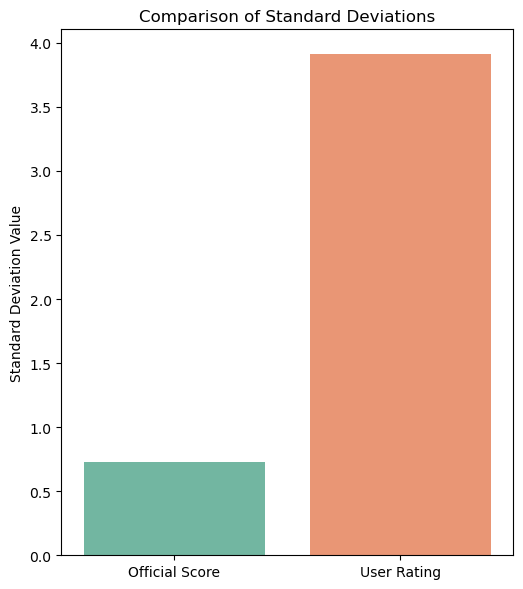

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect the result for analysis
summary = summary_stats.collect()[0]
stddev_score = summary['stddev_score']
stddev_my_score = summary['stddev_my_score']

# Visualizing the averages in a bar plot
plt.figure(figsize=(10, 6))


# Bar plot for standard deviation comparison
plt.subplot(1, 2, 2)
sns.barplot(x=["Official Score", "User Rating"], y=[stddev_score, stddev_my_score], hue=["Official Score", "User Rating"], palette="Set2", legend=False)
plt.title("Comparison of Standard Deviations")
plt.ylabel("Standard Deviation Value")

# Show the plots
plt.tight_layout()
plt.show()

In [23]:
# 2. Grouping and Filtering: Group by 'gender' and Calculate Aggregates
grouped_by_gender = spark.sql("""
    SELECT 
        gender, 
        COUNT(*) AS total_users, 
        AVG(my_score) AS avg_my_score
    FROM anime_data
    GROUP BY gender
""")
print("Grouping by Gender:")
grouped_by_gender.show()

Grouping by Gender:


+----------+-----------+------------------+
|    gender|total_users|      avg_my_score|
+----------+-----------+------------------+
|    Female|    9678908|  4.24000145470956|
|Non-Binary|     240434|3.7598509362236623|
|      Male|   25386353|  4.73323486047799|
+----------+-----------+------------------+



In [24]:
# Collect the results into a Pandas DataFrame for easier analysis
grouped_by_gender_df = grouped_by_gender.toPandas()

# Insight 1: Gender-wise distribution of users
total_male_users = grouped_by_gender_df[grouped_by_gender_df['gender'] == 'Male']['total_users'].values[0]
total_female_users = grouped_by_gender_df[grouped_by_gender_df['gender'] == 'Female']['total_users'].values[0]

print("\nInsight:")
print(f"Total male users: {total_male_users}")
print(f"Total female users: {total_female_users}")

# Insight 2: Comparing average scores by gender
avg_male_score = grouped_by_gender_df[grouped_by_gender_df['gender'] == 'Male']['avg_my_score'].values[0]
avg_female_score = grouped_by_gender_df[grouped_by_gender_df['gender'] == 'Female']['avg_my_score'].values[0]

print(f"Average score for male users: {avg_male_score}")
print(f"Average score for female users: {avg_female_score}")

# Insight 3: Gender with higher average score
if avg_male_score > avg_female_score:
    print("Males have a higher average score.")
else:
    print("Females have a higher average score.")



Insight:
Total male users: 25386353
Total female users: 9678908
Average score for male users: 4.73323486047799
Average score for female users: 4.24000145470956
Males have a higher average score.


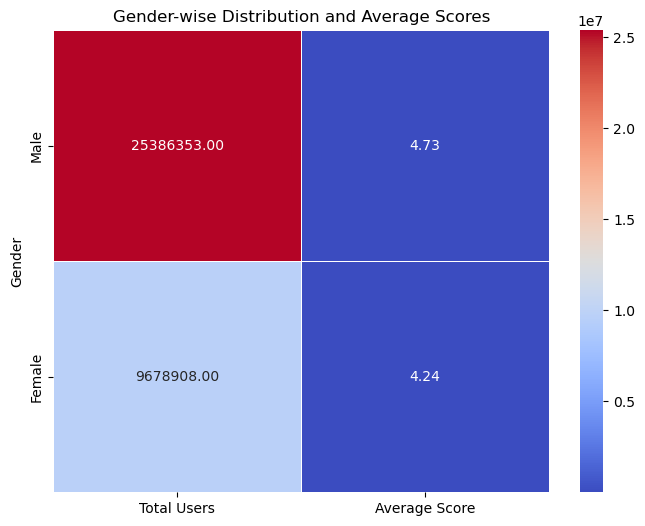

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for the heatmap based on gender, total users, and average score
heatmap_data = {
    'Gender': ['Male', 'Female'],
    'Total Users': [total_male_users, total_female_users],
    'Average Score': [avg_male_score, avg_female_score]
}

heatmap_df = pd.DataFrame(heatmap_data)

# Set the index to 'Gender' for better readability in the heatmap
heatmap_df.set_index('Gender', inplace=True)

# Create the heatmap with a different color scheme (coolwarm)
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
plt.title("Gender-wise Distribution and Average Scores")
plt.show()


In [45]:
# 3. Joining: Example Join with a Hypothetical Users Table (if available)
# Assuming we have another DataFrame called `user_info` with `user_id` and `age`.
user_data = [
    (4614676, 25), (201829, 30), (4297901, 28), (419841, 22), (64770, 27)
]
user_columns = ["user_id", "age"]
user_info = spark.createDataFrame(user_data, user_columns)

# Join on 'user_id'
joined_df = df_normalized.join(user_info, on="user_id", how="inner")
print("Joined Data:")
joined_df.show()

Joined Data:


+-------+---------+--------+--------+------+--------------------+-------+------------+-----+---------+------+----------+--------------------+------------------+---+
|user_id| username|anime_id|my_score|gender|               title|   type|      source|score|scored_by|  rank|popularity|               genre|  normalized_score|age|
+-------+---------+--------+--------+------+--------------------+-------+------------+-----+---------+------+----------+--------------------+------------------+---+
| 201829|slipkorna|    6880|       7|  Male|  Deadman Wonderland|     TV|       Manga| 7.41| 368860.0|1966.0|      53.0|Action, Sci-Fi, H...| 0.749659843997372| 30|
| 201829|slipkorna|     553|       6|  Male|     Yami no Matsuei|     TV|       Manga| 7.19|  18684.0|2874.0|    1800.0|Comedy, Drama, Fa...| 0.719727899850703| 30|
| 201829|slipkorna|    5118|       7|  Male|Suzumiya Haruhi-c...|    ONA|4-koma manga| 7.58|  40899.0|1414.0|    1051.0|      Comedy, Parody|0.7727891060031543| 30|
| 201829|s

In [47]:
# Calculate the average normalized score by age group
age_group_insight = joined_df.groupBy("age").agg(
    avg("normalized_score").alias("avg_normalized_score")
).orderBy("age")

# Show the insights by age
print("Average Normalized Score by Age Group:")
age_group_insight.show()

# Additional insight: Calculate the total number of users in each age group
age_group_count = joined_df.groupBy("age").count().orderBy("age")

# Show the total number of users in each age group
print("Total Users by Age Group:")
age_group_count.show()


Average Normalized Score by Age Group:


+---+--------------------+
|age|avg_normalized_score|
+---+--------------------+
| 22|  0.7572165527347544|
| 25|  0.7529176978922437|
| 27|  0.7926571656835218|
| 28|  0.7844132811542424|
| 30|   0.790651382877956|
+---+--------------------+

Total Users by Age Group:


+---+-----+
|age|count|
+---+-----+
| 22|  481|
| 25|  801|
| 27|  199|
| 28|  537|
| 30|  365|
+---+-----+



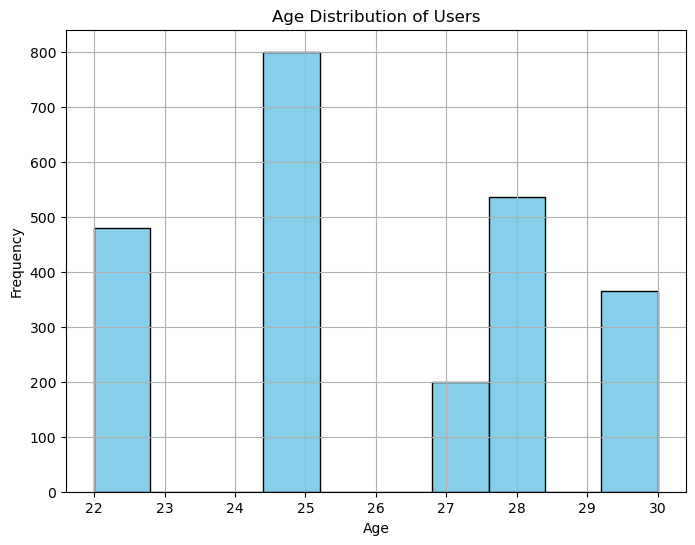

In [24]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
joined_df_pandas = joined_df.toPandas()

# Visualizing the age distribution of the users in the joined dataset
plt.figure(figsize=(8, 6))
plt.hist(joined_df_pandas['age'], bins=10, color='skyblue', edgecolor='black')
plt.title("Age Distribution of Users")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


The analysis of the dataset involved several key steps:

1. Aggregation: Summary statistics (average and standard deviation) for the "score" and "my_score" columns were computed.
2. Grouping by Gender: Data was grouped by gender to analyze average user scores and the total number of users in each group.
3. Joins: A user_info DataFrame was joined with the anime_data to combine user age and anime data.
4. Time-based Analysis: Not performed due to the absence of time-related columns.

Key insights revealed that male users had higher average scores than females, the official scores were higher than user ratings, and age groups showed varying levels of normalized scores.

***4. Machine Learning Model (Regression/Classification)***

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import FloatType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [4]:
# Initialize Spark Session
spark = SparkSession.builder.appName("AnimeScorePrediction").config("spark.driver.memory", "8g").config("spark.executor.memory", "4g").getOrCreate()

# Load the dataset
df = spark.read.csv("animedataset.csv", header=True, inferSchema=True)

# Check schema to ensure correct data types
df.printSchema()



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/06 23:07:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/06 23:07:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/11/06 23:07:03 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/11/06 23:07:03 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/11/06 23:07:03 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
24/11/06 23:07:03 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.


root
 |-- username: string (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- my_score: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- source: string (nullable = true)
 |-- score: string (nullable = true)
 |-- scored_by: double (nullable = true)
 |-- rank: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- genre: string (nullable = true)



In [6]:
# Create a 'label' column (1 if my_score >= 7, else 0)
df = df.withColumn("label", when(col("my_score") >= 7, 1).otherwise(0))

# Select available numeric features (remove 'normalized_score' if it doesn't exist)
selected_features = ["score", "scored_by", "popularity"]


In [8]:
# Handle categorical columns using StringIndexer
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index", handleInvalid="keep")
type_indexer = StringIndexer(inputCol="type", outputCol="type_index", handleInvalid="keep")

assembler = VectorAssembler(
    inputCols=["gender_index", "type_index", "score", "scored_by", "popularity"],
    outputCol="features",
    handleInvalid="skip"  # or "keep"
)

In [10]:
# Split the data into training and test sets
train, test = df.randomSplit([0.8, 0.2], seed=42)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10, maxDepth=5)

# Build a pipeline with the preprocessing steps and classifier
pipeline = Pipeline(stages=[gender_indexer, type_indexer, assembler, rf])


In [12]:
from pyspark.sql.functions import col

# Cast the score column to DoubleType or FloatType
train = train.withColumn("score", col("score").cast("double"))
test = test.withColumn("score", col("score").cast("double"))



In [14]:
train_sample = train.sample(fraction=0.1, seed=42)  # Adjust fraction as needed
test_sample = test.sample(fraction=0.1, seed=42)
# Train the model
model = pipeline.fit(train_sample)

# Make predictions on the test set
predictions = model.transform(test_sample)


24/11/06 23:07:23 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [16]:
# Display sample predictions
predictions.select("username", "my_score", "label", "prediction").show(10)

# Evaluate the model using accuracy metric
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.2f}")

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print(f"Test F1-Score: {f1_score:.2f}")


+---------+--------+-----+----------+
| username|my_score|label|prediction|
+---------+--------+-----+----------+
|-Ackerman|       7|    1|       0.0|
|-Ackerman|       9|    1|       1.0|
|-Ackerman|       8|    1|       1.0|
|-Ackerman|       7|    1|       1.0|
|-Ackerman|       8|    1|       1.0|
|-Ackerman|       6|    0|       0.0|
|-Ackerman|       7|    1|       0.0|
|-Ackerman|       7|    1|       0.0|
|-Ackerman|       8|    1|       0.0|
|-Ackerman|       6|    0|       0.0|
+---------+--------+-----+----------+
only showing top 10 rows



Test Accuracy: 0.60


Test F1-Score: 0.60


A classification model was developed to predict anime ratings (high or low) based on features. The dataset was split into 80% training and 20% testing. Key steps included feature engineering, where user ratings above seven were labeled as 1 (high) and others as 0 (low). Categorical columns were transformed using StringIndexer, and features were combined into a "features" vector using VectorAssembler. A RandomForestClassifier was used for prediction, and the model was trained on 10% samples from the training and test sets. Performance was evaluated with an accuracy of 60% and an F1-score of 0.60.

***5. Model Tuning and Evaluation***

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import when, col
from pyspark.sql.types import DoubleType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [19]:
# Preprocess categorical features (e.g., gender)
gender_indexer = StringIndexer(inputCol="gender", outputCol="genderIndex")

# Initialize the VectorAssembler with actual column names
assembler = VectorAssembler(
    inputCols=["anime_id", "user_id", "genderIndex", "score"],
    outputCol="features"
)

# Initialize the model (e.g., Linear Regression)
lr = LinearRegression(featuresCol="features", labelCol="my_score")


In [31]:
# Define a ParamGrid with a limited set of hyperparameters
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1])  
             .addGrid(lr.elasticNetParam, [0.0, 0.5])
             .build())

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="my_score", predictionCol="prediction", metricName="rmse")

# Assuming 'predictions' is the DataFrame containing the model's predictions
rmse_value = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse_value}")


Root Mean Squared Error (RMSE): 5.649856891520381


In [21]:
# Setup CrossValidator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  
crossval.setParallelism(2)  


CrossValidator_e4ce651119cc

In [22]:
# Define the pipeline with preprocessing and model
pipeline = Pipeline(stages=[gender_indexer, assembler, crossval])


In [23]:
# Apply threshold and cast columns to DoubleType
threshold = 0.5  # Modify as needed
predictions = predictions.withColumn("predictionClass", when(col("prediction") >= threshold, 1).otherwise(0).cast(DoubleType()))
predictions = predictions.withColumn("labelClass", when(col("my_score") >= threshold, 1).otherwise(0).cast(DoubleType()))

# Initialize the evaluator for accuracy and F1 score
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="labelClass", predictionCol="predictionClass", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="labelClass", predictionCol="predictionClass", metricName="f1")

# Calculate accuracy and F1 score
accuracy = accuracy_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")


Accuracy: 0.5446927493119667
F1 Score: 0.5493707998358963


Model tuning involved hyperparameter optimization using cross-validation to improve performance. Categorical data, like gender, was transformed into numeric indices using StringIndexer. Features were combined into a single vector with VectorAssembler, and a Linear Regression model was used to predict user scores. Cross-validation ran through three rounds, adjusting regularization parameters to avoid overfitting, with Root Mean Squared Error (RMSE) used to evaluate the model. The final model's performance was assessed using accuracy (54.47%) and F1-score (0.55), showing moderate success in classification but highlighting areas for improvement in precision and recall balance.